## Wikipedia changes and world events
#### Analysis of national wikipedia changes and world events.
<br>
##### EPFL 2017 - Aplied Data Analysis<br>
authors: George Abi Younes, Amaury Combes, Patryk Oleniuk


In [14]:
import requests
import json
import time
from datetime import date
from datetime import datetime
from helpers.history_fetcher import HistoryFetcher
import dateutil.parser
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import gdelt # pip install gdelt
import folium
import os
from tqdm import tqdm_notebook # conda install tqdm
import operator
import helpers.wiki_helpers as wiki_helpers
import helpers.stats_helpers as stats_helpers
from helpers.wiki_helpers import analyse_wiki_events_correlation_QuadClass, plot_most, distance_from_line, truncate_names, get_stability_for_country, make_folium_map, wiki_change_factor
import pylab 
import scipy.stats as stats

import warnings
warnings.filterwarnings('ignore')

import itertools

%load_ext autoreload
%autoreload 2

pd.options.mode.chained_assignment = None

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


---
### Introduction

Our project idea came from the observation that some wikipedia pages seems to get updated a lot after a related events happens. This could be observed during the Catalonia crisis that happened in september-october 2017, Ukraine War in Donbass and many others. We then wondered how we could exploit this information and quickly agreed that those changes could be correlated to a country's stability. Therefore, the project aims to build a stability index for countries using wikipedia data.

#### Reserach Questions
1. Is the number of changes in country-clustered Wikipedia information a good indicator of stability of the country? Could we try do estimate the stability of a country by this factor ? 


2. How often do citizens contribute to Wikipedia and does it depend on the countries' wealth?

3. Which type of events cause the most changes in Wikipedia? 

4. Which countries react very frequent and on-time with putting events in their Wikipedia page?

#### Maps info
There are folium maps in this notebook. If youre viewing in on Github, open it here to see the maps:<br>
https://nbviewer.jupyter.org/github/patryk-oleniuk-epfl/data-analysis-project/blob/master/Final-notebook.ipynb

#### Part I - Ukraine Case Study

The first step for our project was then to find evidence of the correlation between events and edits on wikipedia. To tackle this problem we decided to take a special case: the 2014 Ukraine war. Our approach is to show a visual argument (plot) that confirms our intuition.

#### Part II - Gather the wikipedia and GDELT data 
Because this task is simple scripting and filtering of the data, it si included in GDELT_auto_event_analysis.ipynb . 
1. GDELT Events aggregated by day by "gdelt" package <br>
    We gather the amount of events with 4 different classes (Quadclass) per day, per country from 2011 to 2017. The event classes are:
        - Verbal Cooperation
        - Material  Coopoeration
        - Verbal Conflict
        - Material Conflict

    Since, GDELT has lots of Data (2011-2017 is around 100GB of unfiltered data) this step is done in a Google cloud server with configurable Memory and then aggregated per day per country and saved into only 50MB aggregated_gdelt.pckl.
2. Wikipedia Data - Wikipedia Internet Data by requests.
We coded out own class "History Fetcher" which is able to fetch the history of countries wikipedia for a gvent dates.
3. UNData <br>
( country-codes.csv, UNdata_GDP.csv, nr_people_all.csv, nr_people_internet )<br>
Using This datasets, (country-codes.csv, ???.csv ???)we were able to fetch different codes for the countries, as well as its population and % of internet users.

In this notebook we just show our combined dataframe with the aforementioned data.


#### Part III - Analysing the Wikipedia Stability

Knowing that the causility between events and wikipedia edits exist, we then decided to design a "countries wikipedia stability index" to see which countries have stable and which have unstable wikipedias and what can we learn from this.

#### III.1 - First Aproach ( mean based )

This is a simple, first approach to this problem. It is not perfect though.

#### III.2 - Second Approach ( MLE based )
This classifier is based on an MLE equation and gives a bit more reliable results

#### Part IV - Wikipedia and GDELT Pearson Correlation

Finally, we analyse how much the general events are correlated with its national wikipedia. 

#### Part V - Mean wikipedia usage analysis

Here we analyse statisctis for mean wikipedia usage for different countries and try to find some rules of thumb.

#### Part VI - Conclusions and Answers
 Here we try to connclude about the quality of our analisys and answer the research questions



---
### Part I - Finding evidence of the implication: main events => lots of wikipedia edits

#### 1 - Find a dataset that contains events for the Ukraine war. 

Intialy we selected the UCDP GED dataset. Unfortunately, as this dataset contains only armed events, we were not able able to find a good visual argument for our intuition. We thus decided to switch to a richer dataset: GDELT events. In order to handle the data, we used a library called **gdeltPyR**.

In [ ]:
# Initialize our GDELT fetcher and fetch data
gd1 = gdelt.gdelt(version=1)
results = gd1.Search(['2014 February 01','2014 April 30'],table='events')
cols_to_keep = ['SQLDATE','ActionGeo_CountryCode','ActionGeo_ADM1Code', 'ActionGeo_Type' ]
results = results[cols_to_keep]

We decided to select only events that occured between 02.01.2014 and 04.30.2014 as this timeframe bounds the beginning of the war.

#### 2 - Grab the history (i.e. edits) of Ukraine's wikipedia page.

In order to grab the edits history for any wikipedia page, we used wikipedia's API and proxied it through our HistoryFetcher class. 

In [2]:
# Fetches Ukraine's wikipedia page history
history_fetcher = HistoryFetcher('Ukraine')
response = history_fetcher.get_history('20140201000000', '20140430000000')

# Keeps only the date field for each edit
ukraine_edits_dates = list(map(lambda revision: revision['timestamp'], response))

#### 3 - Plot the number of edits and events over time

This task was done ploting simple histograms with matplotlib. Both curve are normalized for visibility purposes. 

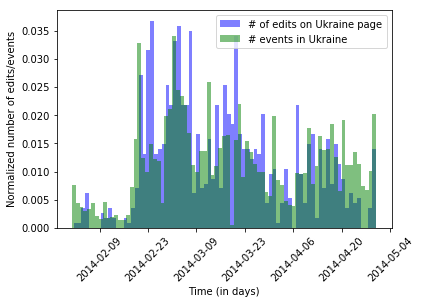

In [51]:
# Add historgram for the number of edits on ukraine's wikipedia page (normalized)
n_wiki, bins_wiki, patches_wiki = plt.hist(ukraine_edits_dates,\
                                           bins=79,\
                                           normed=True,\
                                           color='blue',\
                                           alpha=0.5,\
                                           label='# of edits on Ukraine page')

# Add histogram for the number of events (normalized)
n_event, bins_event, patches_event = plt.hist(ukraine_events_dates,\
                                              bins=79,\
                                              color='green',\
                                              normed=True,\
                                              alpha=0.5,\
                                              label='# events in Ukraine')

plt.xticks(rotation=45)
plt.xlabel('Time (in days)')
plt.ylabel('Normalized number of edits/events')
plt.legend(loc='upper right')
plt.show()

In [17]:
print('Pearson coefficient for our two normalized series is:', np.corrcoef(n_wiki, n_event)[1, 0], '\nThis is a rather high value that emphasize our intuition.')

Pearson coefficient for our two normalized series is: 0.646269617313 
This is a rather high value that emphasize our intuition.


#### Conclusions

This initial investigation, by combining data from two sources, provides arguments towards the causality between events and edits on wikipedia. 

### Part II -  Gather the Wikipedia, GDELT and countries info data 
Full data scraping and filtering, executen on the Google Cloud server because of the amount of Memory, is shown in GDELT_auto_event_analysis.inpynb

Here we just load the data that we gathered during that phase, including:
1. GDP, population, % of internet users
2. Mean Wikipedia Changes
3. Here we also see the other properties calculaten in the next sections.

In [3]:
aggregated_gdelt = pd.read_pickle( 'data/aggregated_gdelt_QuadClass.pckl')
aggregated_gdelt.sample(5)

,SQLDATE,ActionGeo_CountryCode,QuadClass,Counter
1243960,2014-01-01,AY,Verbal Conflict,1.0
502793,2016-10-22,ER,Verbal Cooperation,11.0
1855498,2013-05-08,TH,Verbal Cooperation,4.0
2174113,2012-08-20,TH,Verbal Conflict,33.0
1061987,2016-02-01,SL,Material Cooperation,19.0


In [59]:
countries_data = pd.read_pickle( 'data/countries_data.pckl')
countries_data[['Code numeric', 'FIPS', 'Code', 'Country', 'Region',
       'Population[k]', 'Internet Users%', 'Internet users[k]',
       'GDP', 'GDP per capita']].sample(5)

,Code numeric,FIPS,Code,Country,Region,Population[k],Internet Users%,Internet users[k],GDP,GDP per capita
61,268.0,GG,GEO,Georgia,Asia,3912.061,45.1584,1766.623154,3491.436128,0.892480
36,152.0,CI,CHL,Chile,Americas,18054.726,64.289,11607.202798,13416.230362,0.743087
0,533.0,AA,ABW,Aruba,Americas,105.264,88.6612,93.328354,26005.409405,247.049413
32,124.0,CA,CAN,Canada,Americas,36624.199,88.47,32401.428855,43205.642906,1.179702
139,682.0,SA,SAU,Saudi Arabia,Asia,32938.213,69.6162,22930.344031,20710.576494,0.628770


Please note: The *countries_data* dataframe is loaded from file and also includes theresults of the  further analysis.

---
### Part III -  Countries' Wikipedia Stability index

With this part we're trying to analyse the rate of wikipedia changes to estimate the stability of the country and its other factors. We believe this analysis is interesting and could draw very interesting conclusions and could also help to find events that causw wikipedia change.

### Analysis of Wikipedia changes - #1 approach

We designed a simple classifier function ( $wiki\_change\_factor(...)$ ) to show how many time wikipedia content varies in time fo a given wikipedia page. Our classifier is based on the mean of the wikipedia changes. If for some month there are number of changes that vary from the mean value too much (more than outlier_factor * mean), we mark this event as "out of normal behaviour" and at the end we sum these events and divide by the whole number of wiki changes for the period.

We use our own tunable outlier detector to detect the time periods with extraordinary edit rates and label those as outliers.
The extraordinary monthly edits $ edits_{eo}$ and significant monthly edits $ edits_{sig}$ are classified as follows:
$$
edits_{eo} = edits \geq c_{oef} \cdot avg(edits_{tot})
$$
$$
edits_{sig} = edits \geq 0.7 \cdot c_{oef} \cdot avg(edits_{tot}) 
$$
and $$
edits_{sig} \notin edits_{eo}
$$
Finally, the instability index $ r $ is calculated:
$$
r  = \frac{\sum{{edits_{eo}}} + 0.2 \cdot \sum{{edits_{sig}}}}{\sum{{edits_{tot}}}} 
$$
where $_{eo}$ subscript stands for extraordinary daily edits, $_{sig}$ for significant edits and $_{tot}$ for all edits. 
The $coeff$ has been chosen experimentally as
$$
c_{oef} = 3.4 
$$

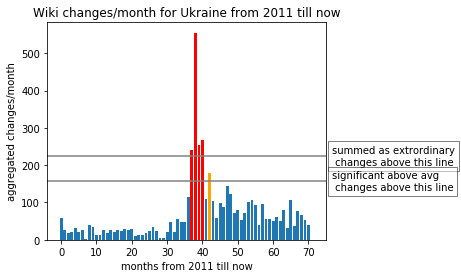

Wikipedia Instability for Ukraine : 0.28529225575


In [3]:
inst_uk = wiki_change_factor('Ukraine', 2011,2017, outlier_factor=3.4, plot_on=True)
print('Wikipedia Instability for Ukraine :', inst_uk)

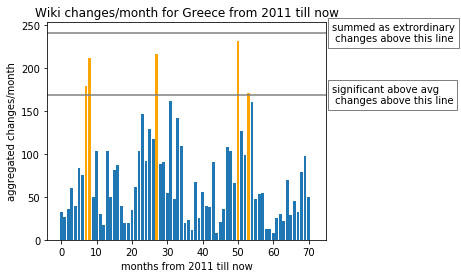

Wikipedia Instability for Greece : 0.0395694716243


In [4]:
inst_nr = wiki_change_factor('Greece', 2011, 2017, outlier_factor=3.4, plot_on=True)
print('Wikipedia Instability for Greece :', inst_nr)

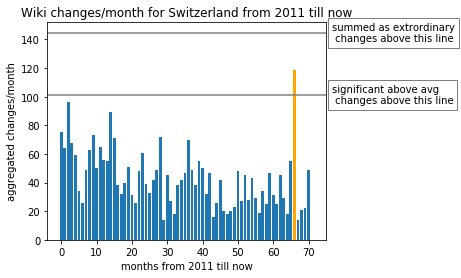

Wikipedia Instability for Swizterland : 0.00776508972268


In [6]:
inst_nr = wiki_change_factor('Switzerland', 2011, 2017, outlier_factor=3.4, plot_on=True)
print('Wikipedia Instability for Swizterland :', inst_nr)

As we can see above, our classifier is able to detect major events in wikipedia changes and assign a numerical
value to the countries wikipedia stability.

We run this classifier for all world countries and saved the instability results into our pandas dataframe.



In [4]:
countries_data[[ 'Country', 'Region', 'Wiki Instability old']].sample(5)

,Country,Region,Wiki Instability old
58,French Polynesia,Oceania,0.023158
136,Puerto Rico,Americas,0.112779
86,Kazakhstan,Asia,0.000000
97,Malawi,Africa,0.013818
76,India,Asia,0.000000


<br>
#### Comparing World Countries - Map instability index #1
By plotting this coefficient values for different countries, we can plot a Map with different Wikipedia dynamism rate 

In [5]:
colors_eu = ['#fff7fb', '#ece2f0', '#d0d1e6', '#a6bddb', '#67a9cf', '#3690c0', '#02818a', '#016c59',  '#014636','#114636' ]
thresh_eu = np.linspace(0,0.6,9)


def wiki_changes_colors_eu(state):
    """Maps Unemplpoyment value with colors."""
    try:
        val = countries_data[countries_data['Code']==state]['Wiki Instability old'].values[0]
    except:
        return '#bdbdbd'
    if np.isnan(val):
        return '#bdbdbd'
    length = len(thresh_eu)
    for i in range(0, length-1):
        if val < thresh_eu[i]:
            return colors_eu[i]
    return  colors_eu[length-1]


m = make_folium_map('maps/world-countries-sans-antarctica.json', 'objects.countries1',
                    wiki_changes_colors_eu, 0.0, np.max(thresh_eu), colors_eu, 
                    [56,10], 2, '% Wikipedia instability')

m

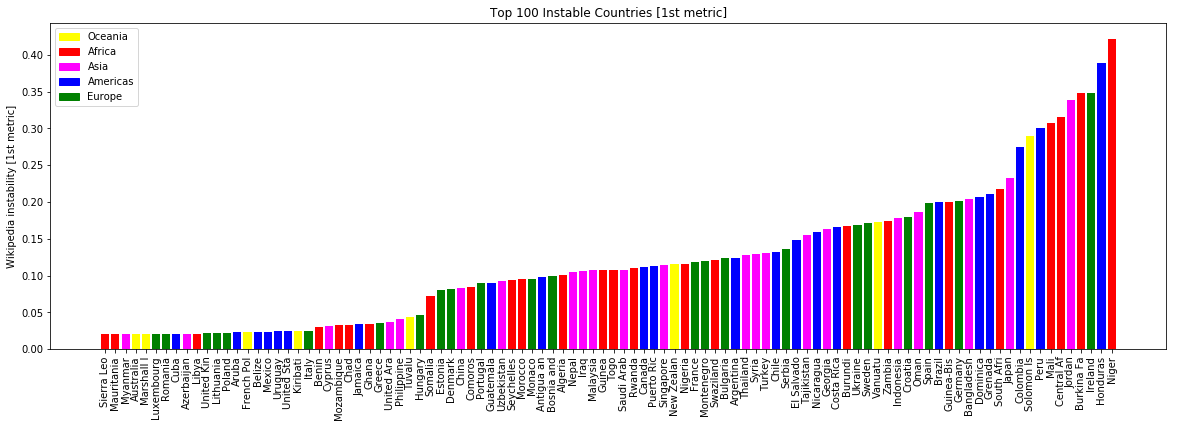

In [26]:
plot_most(countries_data, 'Wiki Instability old',title=' Instable Countries [1st metric]' ,nr_top=100, figsize=(20, 6))

We could observe, that  as expected some very developed and stable countries have very stable wikipedia, and the less stable also less stable wikipedia. However we could observe some interesting facts for some nations:
- like expected, Ukraine has lots of instability due to war
- Ireland is the most instable for Europe - this is very strange, but probably the wikipedia community is very exctive.
- Germany, Croatia or Sweden has a lot of instability in its wikipedia -  maybe there are some major events to be correlated.
- The computed instability factor highly depends on computation method, therefore we should prove better that our method is valid.


### Analysis of Wikipedia changes - #2 - MLE based

Taking into account the limitations of our first model, we decided to come up with a second one. In order to do so, we performed a quick exploratory analysis on the data to get some ideas for our new prototype. 

1 - We select the edits history for three countries: Ukraine, France and Switzerland from early 2013 to late 2017

2 - We then split this time window into K smaller timeframes. For each timeframes, we count the number of edits that occured within its boundaries

3 - We then group the timeframes by the number of edits they contain

4 - We then plot the corresponding distribution

#### Selecting history for Ukraine, France and Switzerland

In [3]:
ukraine_history = HistoryFetcher('Ukraine')
ukraine_dates = ukraine_history.get_edits_dates('20130101000000', '20171101000000')

france_history = HistoryFetcher('France')
france_dates = france_history.get_edits_dates('20130101000000', '20171101000000')

swiss_history = HistoryFetcher('Switzerland')
swiss_dates = swiss_history.get_edits_dates('20130101000000', '20171101000000')

#### Split histories into K smaller timeframes

In [4]:
K = 1500

In [5]:
ukraine_timeframes, x, y = plt.hist(ukraine_dates, bins=K)

france_timeframes, x, y = plt.hist(france_dates, bins=K)

swiss_timeframes, x, y = plt.hist(swiss_dates, bins=K)

plt.clf()

#### Grouping timeframes by the number of edits

In [6]:
ua_timeframes_value, ua_nb_of_timeframes_value = wiki_helpers.group_data(ukraine_timeframes)

fr_timeframes_value, fr_nb_of_timeframes_value = wiki_helpers.group_data(france_timeframes)

ch_timeframes_value, ch_nb_of_timeframes_value = wiki_helpers.group_data(swiss_timeframes)

#### Plot the corresponding distribution

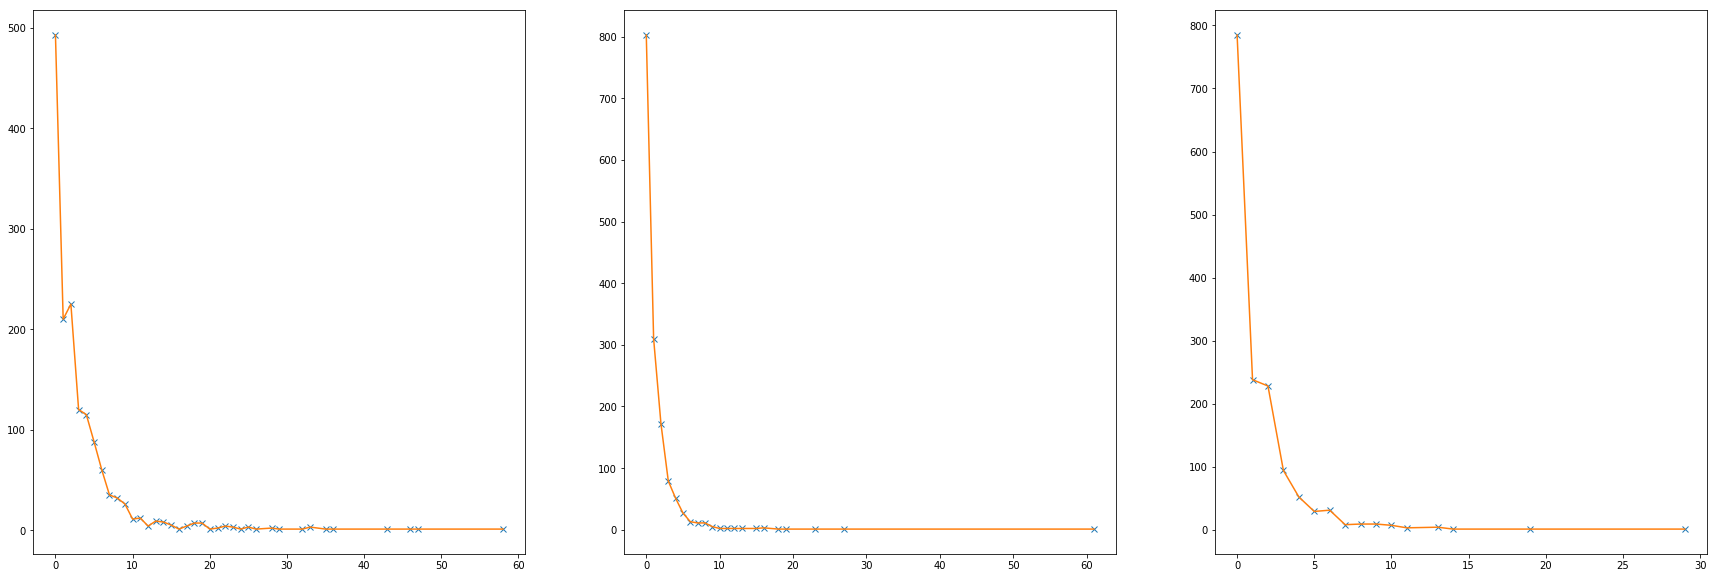

In [7]:
fig, (ax1, ax2, ax3) = plt.subplots(nrows=1, ncols=3, figsize=(30, 10))

ax1.plot(ua_timeframes_value, ua_nb_of_timeframes_value, 'x')
ax2.plot(fr_timeframes_value, fr_nb_of_timeframes_value, 'x')
ax3.plot(ch_timeframes_value, ch_nb_of_timeframes_value, 'x')

ax1.plot(ua_timeframes_value, ua_nb_of_timeframes_value)
ax2.plot(fr_timeframes_value, fr_nb_of_timeframes_value)
ax3.plot(ch_timeframes_value, ch_nb_of_timeframes_value)

plt.show()

We notice that those three distributions look like exponential distributions. Additionaly, Ukraine seems to have a longer tail compared to France and Switzerland. We will thus find the MLE for each of the curves and conclude on the potentiality to use it as our new index.

#### Finding the MLE for each distribution

In [8]:
ukraine_lambda_hat = stats_helpers.exponential_mle(ukraine_timeframes)
france_lambda_hat = stats_helpers.exponential_mle(france_timeframes)
swiss_lambda_hat = stats_helpers.exponential_mle(swiss_timeframes)

#### Plots of our distributions versus the estimated exponential distributions

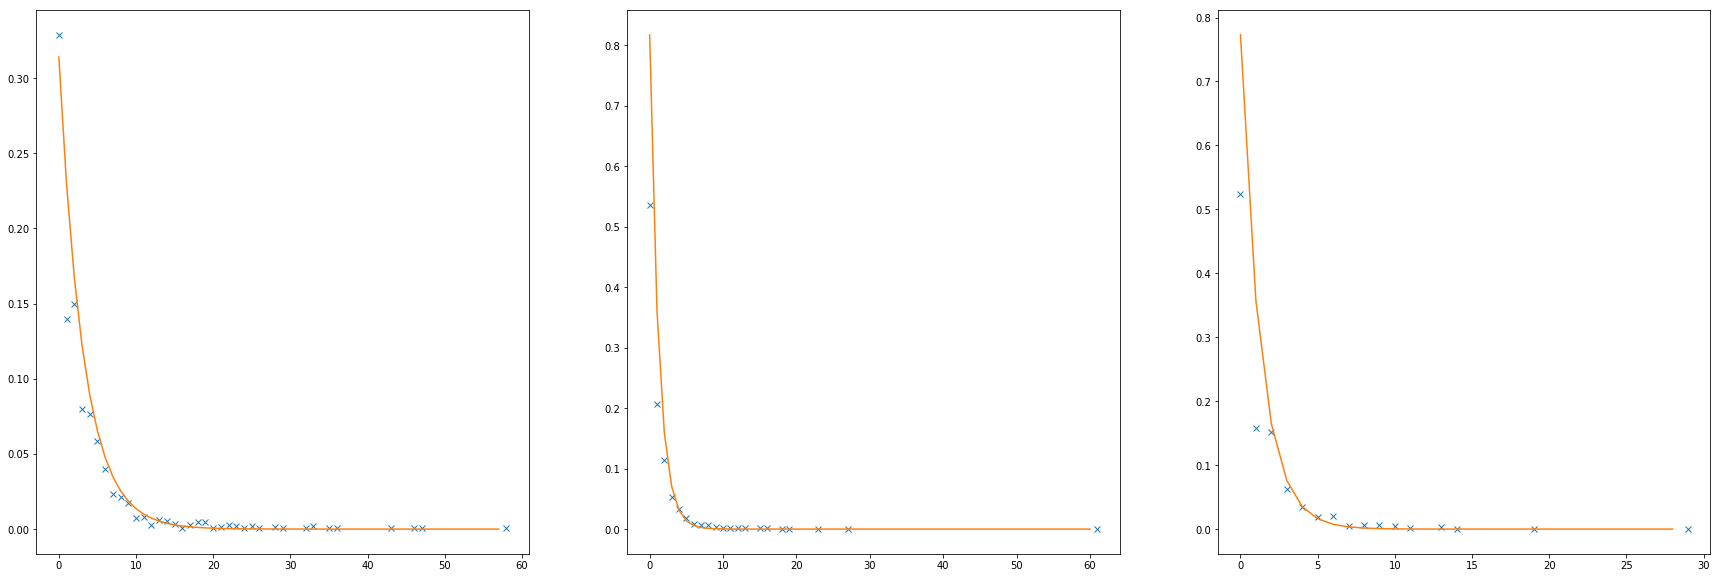

In [9]:
fig, (ax1, ax2, ax3) = plt.subplots(nrows=1, ncols=3, figsize=(30, 10))

ax1.plot(ua_timeframes_value, stats_helpers.normalize(ua_nb_of_timeframes_value), 'x')
ax2.plot(fr_timeframes_value, stats_helpers.normalize(fr_nb_of_timeframes_value), 'x')
ax3.plot(ch_timeframes_value, stats_helpers.normalize(ch_nb_of_timeframes_value), 'x')

ukraine_exponential = [stats_helpers.exponential_density(i, ukraine_lambda_hat) for i in range(int(max(ua_timeframes_value)))]
france_exponential = [stats_helpers.exponential_density(i, france_lambda_hat) for i in range(int(max(fr_timeframes_value)))]
swiss_exponential = [stats_helpers.exponential_density(i, swiss_lambda_hat) for i in range(int(max(ch_timeframes_value)))]

ax1.plot(ukraine_exponential)
ax2.plot(france_exponential)
ax3.plot(swiss_exponential)

plt.show()

The exponential distribution that we estimated seems to fit our data quite well. We plot below the Q-Q plots to get a better idea.

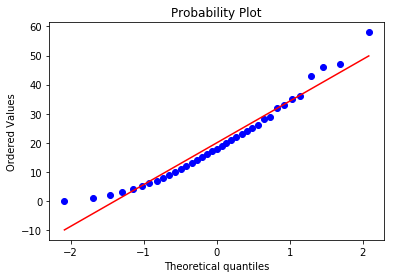

In [15]:
measurements = np.random.exponential(scale=ukraine_lambda_hat, size=1000)   
stats.probplot(ua_timeframes_value, dist="norm", plot=pylab)
pylab.show()

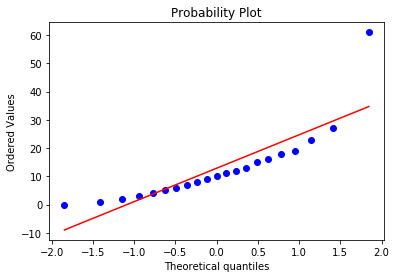

In [16]:
measurements = np.random.exponential(scale=france_lambda_hat, size=1000)   
stats.probplot(fr_timeframes_value, dist="norm", plot=pylab)
pylab.show()

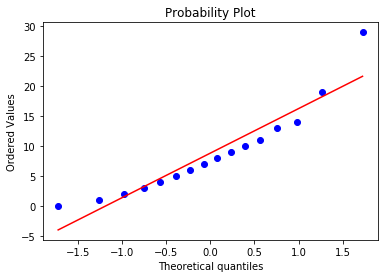

In [17]:
measurements = np.random.exponential(scale=france_lambda_hat, size=1000)   
stats.probplot(ch_timeframes_value, dist="norm", plot=pylab)
pylab.show()

As we can see on the Q-Q plots, our data is roughly suited by an exponential distribution when excluding low and high values. Indeed, the exponential distribution fails to capture our initial values and extreme values (e.g. 60 edits in one timeframe in France).

#### Inspecting the estimated parameters

In [18]:
print('Alpha hat for Ukraine:', ukraine_lambda_hat)
print('Alpha hat for France:', france_lambda_hat)
print('Alpha hat for Switzerland:', swiss_lambda_hat)

Alpha hat for Ukraine: 0.314004605401
Alpha hat for France: 0.816993464052
Alpha hat for Switzerland: 0.772797527048


The estimators we found seem to give a good index as for the statiblity criteria we are trying to proxy. After describing the model a more precisely, we will find this value for many other countries to validate our results.

#### Explaining the model 

The idea behind this model is that we discretize time through multiple random variables:

$T_1,...,T_K \sim Exp(\lambda)$ with density $\text{ }f(x) = \lambda e^{-\lambda x}$ for $x \geq 0$

The realization of those random variables represent the number of edits that occured in the time they span. 

The $\lambda$ parameter give the shape for an exponential distribution. Low values for $\lambda$ yield a much longer tail compared to higher values for $\lambda$. 

We then compute the MLE for $\lambda$ using the following formula:  

$\widehat{\lambda} = \frac{K}{\sum\limits_{i=1}^K T_i}$

Having this estimated value $\widehat{\lambda}$ we can just read the shape parameter and use it to interpret a stability indicator.  

#### Validating our index

In [60]:
colors_eu = ['#fff7fb', '#ece2f0', '#d0d1e6', '#a6bddb', '#67a9cf', '#3690c0', '#02818a', '#016c59',  '#014636','#114636' ]
thresh_eu = np.linspace(0,1.5,9)


def wiki_changes_colors_eu(state):
    """Maps Unemplpoyment value with colors."""
    try:
        val = countries_data[countries_data['Code']==state]['Wiki Stability MLE'].values[0]
    except:
        return '#bdbdbd'
    if np.isnan(val):
        return '#bdbdbd'
    length = len(thresh_eu)
    for i in range(0, length-1):
        if val < thresh_eu[i]:
            return colors_eu[i]
    return  colors_eu[length-1]


m = make_folium_map('maps/world-countries-sans-antarctica.json', 'objects.countries1',
                    wiki_changes_colors_eu, 0.0, np.max(thresh_eu), colors_eu, 
                    [56,10], 2, '% Wikipedia Stability')

m

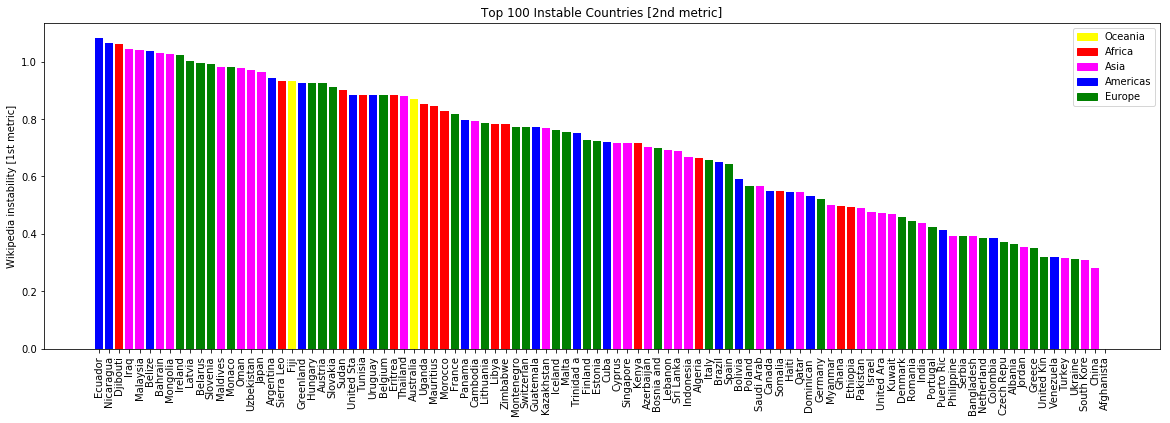

In [29]:
plot_most(countries_data, 'Wiki Stability MLE',title=' Instable Countries [2nd metric]', sort=-1, nr_top=100, figsize=(20, 6))

#### Conclusions, Comments
This is a better type Stability Index - Ukraine is the least stable in Europe, together with Greece, however we could see the the UK is also there. This metric takes into account all the values and therefore could be used to asses the instability of a country better. However, we could see some similar problems than in the index #1, some countries (Germany, Croatia, Ireland) just have lots of peaks in their wikipedia and there are no real "bad events" that happened there. Therefore, we counclude its is very difficult to differ between "good changes" and "bad changes" and hence it is difficult to estimate the countries stability by its wikipedia stability. We also have to take into account that in some countries people dont use english wikipedia a lot, and therefore their english version wikipedia is much more stable.

#### Part IV - GDELT and Wikipedia events correlation.

In this section we're directly correlating the GDELT event data ( 4 event classes, per day) with the Wikipedia changes. Before analysis, the data is aggregated by month to counteract the inter-event peak delays. The correlation coefficient is calculated based on the Person Coefficient between to data series:
Pearson coefficient:

$ \rho = \frac{\text{cov}(X,Y)}{\sigma_x \sigma_y}, \rho \in (0,1) $

$ r = \frac{{}\sum_{i=1}^{n} (x_i - \overline{x})(y_i - \overline{y})}
{\sqrt{\sum_{i=1}^{n} (x_i - \overline{x})^2(y_i - \overline{y})^2}}, r \in (1,1) $

$ result = \rho \cdot r $

which returns $ r \in (-1,1) $ - correlation coefficient and  $p \in (0,1)$ -  the probability that the data is uncorrelated even when having the correlation $r$. For each country we are saving the value $p \cdot r$. This is  to counteract the fact that there are no events in the country and therefore stable Wikipedia will be highly correlated with stable events. This highly increased our accuracy and precision, since if the return values is high the Wikipedia is very probable to be correlated.

We performed this for allw orld countries and saved it to *countries_data* dataframe:

In [52]:
countries_data['Perason Wiki/GDELT Events mo *sur'] = (countries_data['Pearson Corr QuadClass1'] + 
                                                      countries_data['Pearson Corr QuadClass2'] +
                                                      countries_data['Pearson Corr QuadClass3'] +
                                                      countries_data['Pearson Corr QuadClass4'])/4
countries_data[[ 'Country', 'Region', 'Pearson Corr QuadClass1', 'Pearson Corr QuadClass2',
       'Pearson Corr QuadClass3', 'Pearson Corr QuadClass4', 'Perason Wiki/GDELT Events mo *sur']].sample(5)



,Country,Region,Pearson Corr QuadClass1,Pearson Corr QuadClass2,Pearson Corr QuadClass3,Pearson Corr QuadClass4,Perason Wiki/GDELT Events mo *sur
144,Sierra Leone,Africa,0.064382,0.050362,0.124992,0.180984,0.105180
174,United Kingdom,Europe,-0.162612,-0.173425,-0.153131,-0.154838,-0.161002
167,Uruguay,Americas,-0.238067,-0.193419,-0.067099,-0.170090,-0.167169
173,Zimbabwe,Africa,NaN,NaN,NaN,NaN,NaN
25,Belarus,Europe,-0.059444,-0.000066,0.028955,0.020976,-0.002395


In [53]:
colors_eu = ['#fff7fb', '#ece2f0', '#d0d1e6', '#a6bddb', '#67a9cf', '#3690c0', '#02818a', '#016c59',  '#014636','#114636' ]
thresh_eu = np.linspace(-0.45,0.5,9)


def wiki_changes_colors_eu(state):
    """Maps Unemplpoyment value with colors."""
    try:
        val = (countries_data[countries_data['Code']==state]['Pearson Corr QuadClass1'].values[0])
        val += (countries_data[countries_data['Code']==state]['Pearson Corr QuadClass2'].values[0])
        val += (countries_data[countries_data['Code']==state]['Pearson Corr QuadClass3'].values[0])
        val += (countries_data[countries_data['Code']==state]['Pearson Corr QuadClass4'].values[0])
        val = (val)/4
    except:
        return '#bdbdbd'
    
    if np.isnan(val):
        return '#bdbdbd'
    
    length = len(thresh_eu)
    for i in range(0, length-1):
        if val < thresh_eu[i]:
            return colors_eu[i]
    return  colors_eu[length-1]


m = make_folium_map('maps/world-countries-sans-antarctica.json', 'objects.countries1',
                    wiki_changes_colors_eu, -0.5, 0.50, colors_eu, 
                    [56,10], 1.9, '% Pearson wiki edits/gdelt events correlation')

m

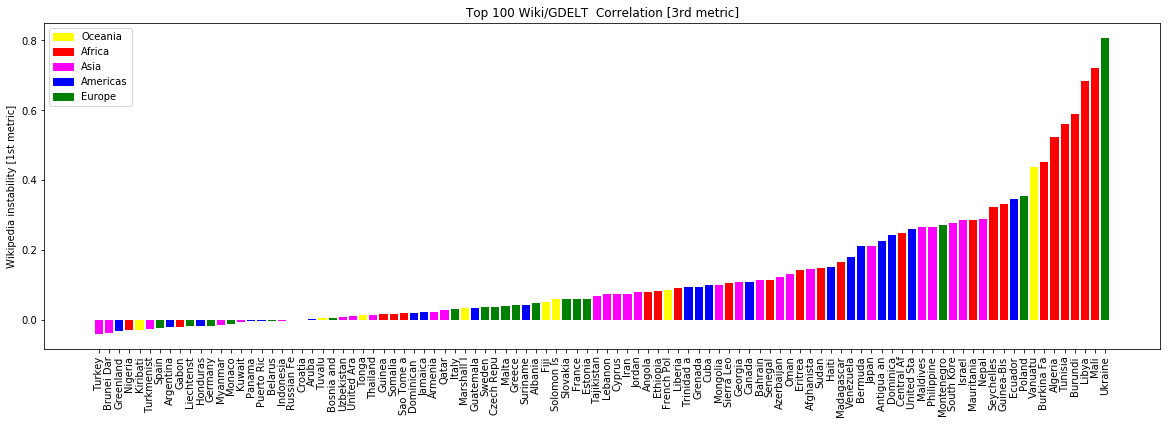

In [54]:
plot_most(countries_data, 'Perason Wiki/GDELT Events mo *sur',title=' Wiki/GDELT  Correlation [3rd metric]', nr_top=100, figsize=(20, 6))

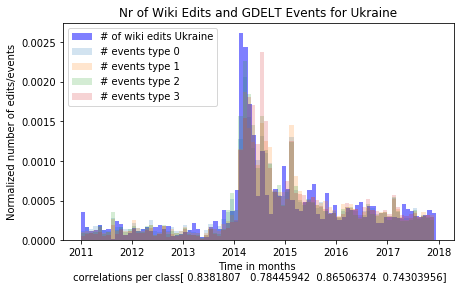

Correlations for event types for Ukraine:  [ 0.8381807   0.78445942  0.86506374  0.74303956]


In [48]:
## example countries
r, s = analyse_wiki_events_correlation_QuadClass(aggregated_gdelt,'UP', 'Ukraine', '20110101000000', '20171215000000', plot=True)
print('Correlations for event types for Ukraine: ', r)

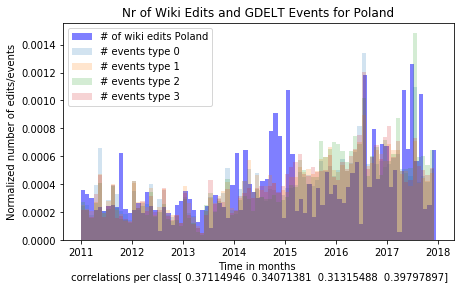

Correlations for event types for Poland:  [ 0.37114946  0.34071381  0.31315488  0.39797897]


In [49]:
## example countries
r, s = analyse_wiki_events_correlation_QuadClass(aggregated_gdelt,'PL', 'Poland', '20110101000000', '20171215000000', plot=True)
print('Correlations for event types for Poland: ', r)

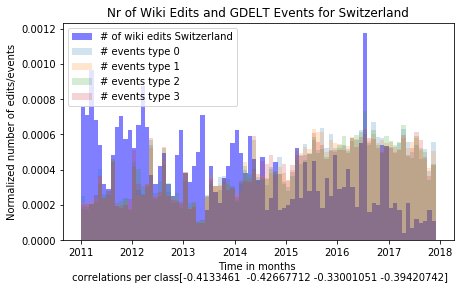

Correlations for event types for Poland:  [-0.4133461  -0.42667712 -0.33001051 -0.39420742]


In [50]:
## example countries
r, s = analyse_wiki_events_correlation_QuadClass(aggregated_gdelt,'CH', 'Switzerland', '20110101000000', '20171215000000', plot=True)
print('Correlations for event types for Poland: ', r)

1. It is very interesting to see Ukraine in the first page.Probably lots of people use internet and were highly affected by Donbass war.
2. Africa - We could see that the North African countries are clustered with very gigh correlations, probably because of the "Arab Spring" happening 2010-2015 and a lot of peaople were contributing wo wikipedia. 
3. High correlations can mean bad (wars) but can also mean very good, it mean that the Wikipedia is reacting to the events. 
4. Some countries that we believe should be highly correlated are not (France, Germany), probably because of the number of unimportant events reported to GDELT which were note relevant to Wikipedia. However, the negative correlations, especially the higher ones, are unexpected.


---
### Part V - Mean wikipedia usage analysis

#### Part V.1 Mean National Wikipedia usage Statistics

1. Load the % of people using internet for all countries database from the UN Data.
2. Load All number of people for all countries database from the UN Data.
3. Merge the 2 dataframes and compute the number of people using internet 

We could colcude, that the 3 values:
- wikipedia mean changes
- number of internet users
- GDP per capita
<br>could be highly correlated. Therefore, we perform further Analysis. 

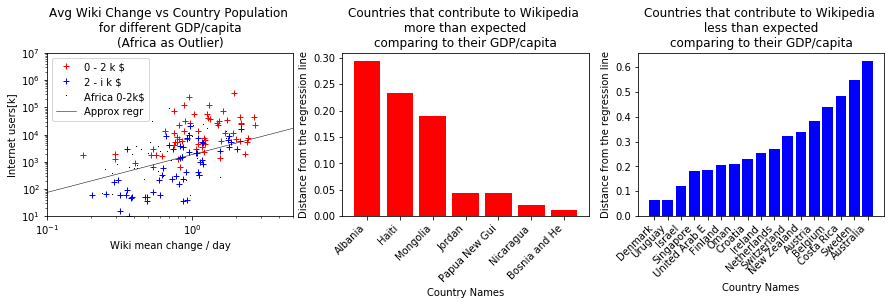

In [15]:
intervals =  np.append(0, np.append([ 2], np.inf))
colors =     ['+r',  '+b', '+y' , '+c',    '+b',   '+k'];

plt.clf()
f = plt.subplot(1,3,1)
f.figure.set_figwidth(16)
plt.hold(True)
for i in range(len(intervals)-1):
    changes = countries_data[countries_data['Region']!='Africa'][(countries_data['GDP per capita'] > intervals[i]) & (countries_data['GDP per capita'] <= intervals[i+1])]['Wiki mean change day'].values
    changes = np.squeeze(changes)
    people = countries_data[countries_data['Region']!='Africa'][(countries_data['GDP per capita'] > intervals[i]) & (countries_data['GDP per capita'] <= intervals[i+1])]['Internet users[k]'].values
    people = np.squeeze(people)
    plt.loglog(changes,people,colors[i])
    
# plotting only Africa outliers
changes = countries_data[countries_data['Region']=='Africa'][(countries_data['GDP per capita'] > 0) & (countries_data['GDP per capita'] <= intervals[1])]['Wiki mean change day'].values    
np.squeeze(changes)
people = countries_data[countries_data['Region']=='Africa'][(countries_data['GDP per capita'] > 0) & (countries_data['GDP per capita'] <= intervals[1])]['Internet users[k]'].values
people = np.squeeze(people)
plt.loglog(changes,people,',k')

# computed previously regression values
a = 1.39
b = 1821
x = [1e-2,1e0, 5, 10]
y = np.power(x,a)*b

# plotting the line
plt.loglog(x,y,'-k',linewidth=0.5)

val_str = []
for i, val in enumerate(intervals[1:]):
    val_str.append(str(intervals[i])[:-2] + ' - ' + str(val)[:-2]+' k $')
val_str.append('Africa 0-2k$')
val_str.append('Approx regr')
plt.legend(val_str)
plt.title('Avg Wiki Change vs Country Population \n for different GDP/capita \n(Africa as Outlier)')
plt.xlabel('Wiki mean change / day')
plt.ylabel('Internet users[k]')
plt.xlim([1e-1, 5])
plt.ylim([1e1, 1e7])


## finding red values below the line and its distnace
changes_log = np.log10(countries_data[countries_data['Region']!='Africa'][(countries_data['GDP per capita'] <= 2.0)]['Wiki mean change day'])
people_log = np.log10(countries_data[countries_data['Region']!='Africa'][(countries_data['GDP per capita'] <= 2.0)]['Internet users[k]'])
distances = distance_from_line(a,np.log10(b),changes_log,people_log)
distances = distances[(~np.isnan(distances)) & ~np.isinf(distances)].sort_values()
# showing top10 countries that are down the line (active wikipedia) but are poor

df_topdown = distances[:7]
names_topdown = countries_data.ix[df_topdown.index.values]['Country'].values
names_topdown = truncate_names(names_topdown, 13)
values_topdown = -df_topdown.values

f = plt.subplot(1,3,2)
f.figure.set_figwidth(16)
plt.bar(range(len(names_topdown)), values_topdown, color="red")
plt.xticks(range(len(names_topdown)),names_topdown, rotation = 45 , ha='right')
plt.title('Countries that contribute to Wikipedia \n more than expected \ncomparing to their GDP/capita')
plt.xlabel('Country Names')
plt.ylabel('Distance from the regression line')

## finding blues values above the line and its distnace
changes_log = np.log10(countries_data[countries_data['Region']!='Africa'][(countries_data['GDP per capita'] >= 2.0)][countries_data['Wiki mean change day'] > 0.1]['Wiki mean change day'])
people_log = np.log10(countries_data[countries_data['Region']!='Africa'][(countries_data['GDP per capita'] >= 2.0)][countries_data['Wiki mean change day'] > 0.1]['Internet users[k]'])
distances = distance_from_line(a,np.log10(b),changes_log,people_log)
distances = distances[(~np.isnan(distances)) & ~np.isinf(distances)].sort_values()
# showing top10 countries that are down the line (active wikipedia) but are poor

df_topup = distances[-17:]
names_topup = countries_data.ix[df_topup.index.values]['Country'].values
names_topup = truncate_names(names_topup, 13)
values_topup = df_topup.values

f = plt.subplot(1,3,3)
f.figure.set_figwidth(15)
plt.bar(range(len(names_topup)), values_topup, color="blue")
plt.xticks(range(len(names_topup)),names_topup, rotation = 45 , ha='right')
plt.title('Countries that contribute to Wikipedia \n less than expected \ncomparing to their GDP/capita')
plt.xlabel('Country Names')
plt.ylabel('Distance from the regression line')

plt.show()

We tried to find correlation between the countries properties and how the Wikipedia is used. We found, that this is highly correlated with the wealth of the citizens. To prove that, we ploted in Figure above the 2 values in double log scale. We could observe clustering, in particular  that the more walthy the country is, the more do citizens contribute to Wikipedia. We also found lots of exceptions, for example Africa totally does not follow this trend and is spread in all the area. Hence, we ran the regression line (in double log axis) without this data. Additionally, afterwards we were able to find which countries contribute less / more (blue + above/ red + below) in comparison to our simple model. We could then find, which countries do NOT follow our regression model, e.g. Australia should contribute much more and Albania, even though is poor relative to others, contributes a lot.

#### Part V.2 - Which event types cause the most wikipedia changes ?

Finally, we analysed which type of events cause the most change in Wikipedia n average. 
We computed a weighted average of correlations for all countries, where the weights are the number of the Internet users.

$ Avg_{class} = \frac{ \sum_{i \in countries}{c_i n_i } }{\sum{ n_i }}$

$ Avg_{class}$ - average per one class (4 classes available )<br>
$ c_i$ - wiki / GDELT correlation for country $i $<br>
$ n_i$ - number of internet users fro country $i$

The results os this analysis is shown below.

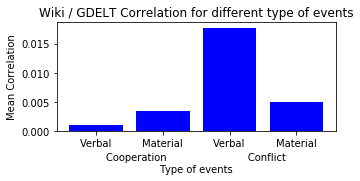

In [55]:
v1= (countries_data['Pearson Corr QuadClass1']*countries_data['Internet users[k]']).sum()/countries_data['Internet users[k]'].sum()
v2= (countries_data['Pearson Corr QuadClass2']*countries_data['Internet users[k]']).sum()/countries_data['Internet users[k]'].sum()
v3= (countries_data['Pearson Corr QuadClass3']*countries_data['Internet users[k]']).sum()/countries_data['Internet users[k]'].sum()
v4= (countries_data['Pearson Corr QuadClass4']*countries_data['Internet users[k]']).sum()/countries_data['Internet users[k]'].sum()
corr_values = [v1,v2,v3,v4]
minimum = np.min(corr_values)
corr_values = np.array(corr_values) - minimum +0.001
plt.clf()
plt.figure(figsize=(5,2))
plt.bar(range(4), corr_values, color="blue")
plt.xticks(range(4),['Verbal','Material','Verbal','Material'])
plt.ylabel('Mean Correlation')
plt.xlabel('Cooperation                          Conflict\nType of events')
plt.title('Wiki / GDELT Correlation for different type of events')
plt.show()

##### As expected the conflicts have much higher correlation, so cause much more changes, than the cooperation. 

### Part VI - Conclusions and Answers
1.**Is the number of changes in country-clustered Wikipedia information a good indicator of stability of the country?** <br> YES , kind of but not very well and it is not very reliable. This depends on the region and type of political / war activities.

2.**How often do citizens contribute to Wikipedia and does it depend on the countries' wealth?** <br> Often, but it depends on wealth and number of internet users

3.** Which event types cause the most wikipedia changes ? ** <br>
Conflicts cause much more changes than cooperation.

In general, each country has also different temperament and political situation, these are lots of factors we didnt take into account.